In [2]:
# Imports and paths
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from collections import OrderedDict

report_dir = Path('../reports') / 'eda'
assert report_dir.exists(), f'Reports directory not found: {report_dir}'

In [3]:
# Load class counts (json + csv are available)
with open(report_dir / 'class_counts.json', 'r') as f:
    class_counts = json.load(f)

# We'll focus on the train split for weighting decisions
train_counts = OrderedDict(sorted(class_counts.get('train', {}).items(), key=lambda x: x[0]))
print('Train class counts:')
for k, v in train_counts.items():
    print(f'  {k}: {v}')

# Wrap in a DataFrame for easy plotting
df_counts = pd.DataFrame(list(train_counts.items()), columns=['class', 'count'])

Train class counts:
  fall armyworm: 116
  grasshoper: 539
  healthy: 166
  leaf beetle: 747
  leaf blight: 792
  leaf spot: 993
  streak virus: 775


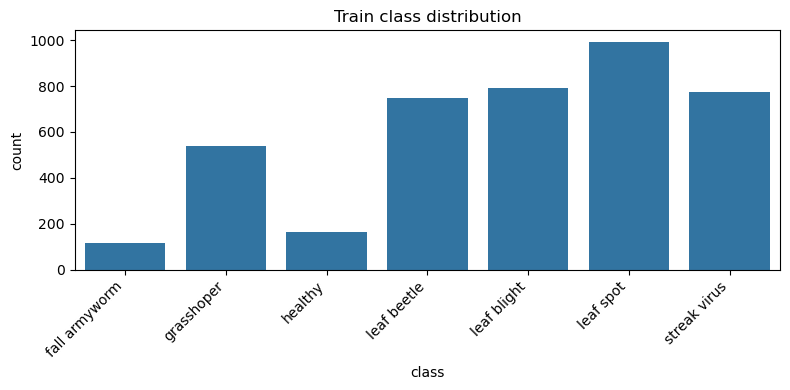

In [4]:
# Plot the class distribution (train)
plt.figure(figsize=(8,4))
sns.barplot(data=df_counts, x='class', y='count')
plt.xticks(rotation=45, ha='right')
plt.title('Train class distribution')
plt.tight_layout()
plt.show()

Computed class weights (for CrossEntropyLoss):
           class  count    weight
0  fall armyworm    116  5.083744
1     grasshoper    539  1.094090
2        healthy    166  3.552496
3    leaf beetle    747  0.789443
4    leaf blight    792  0.744589
5      leaf spot    993  0.593871
6   streak virus    775  0.760922


/var/folders/_x/wjx53tmd44352n7zmhrvy4hm0000gn/T/ipykernel_4234/2127492840.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x='class', y='weight', palette='viridis')


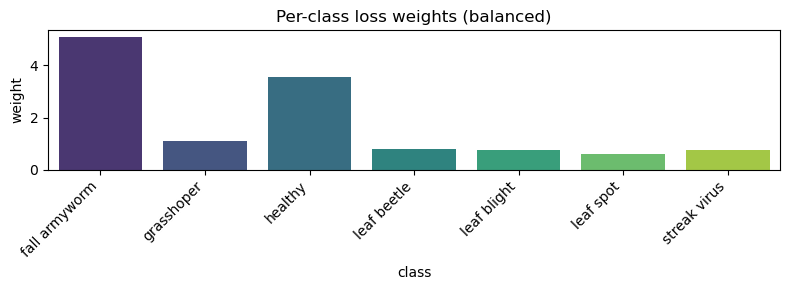

Torch class weight tensor:
tensor([5.0837, 1.0941, 3.5525, 0.7894, 0.7446, 0.5939, 0.7609])


In [7]:
# Compute class weights consistent with `train: CrossEntropyLoss(weight=class_weights)`
# Following the training script: weight_i = total / (num_classes * count_i)
num_classes = len(df_counts)
total = df_counts['count'].sum()
df_counts['weight'] = df_counts['count'].apply(lambda c: total / (num_classes * c))
print('Computed class weights (for CrossEntropyLoss):')
print(df_counts[['class','count','weight']])

# Visualize weights
plt.figure(figsize=(8,3))
sns.barplot(data=df_counts, x='class', y='weight', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Per-class loss weights (balanced)')
plt.tight_layout()
plt.show()

# Example: create a torch tensor suitable for CrossEntropyLoss
class_weight_tensor = torch.tensor(df_counts['weight'].values, dtype=torch.float)
print('Torch class weight tensor:')
print(class_weight_tensor)

Image sizes sample (first rows):


,width,height
0,224,224
1,224,224
2,224,224
3,224,224
4,224,224


Sizes summary:
        width  height
count  5000.0  5000.0
mean    224.0   224.0
std       0.0     0.0
min     224.0   224.0
25%     224.0   224.0
50%     224.0   224.0
75%     224.0   224.0
max     224.0   224.0


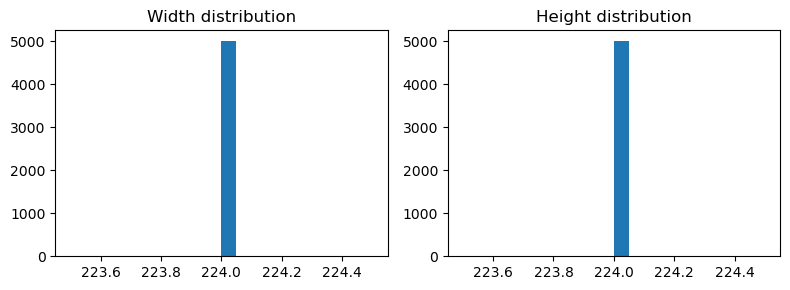

In [8]:
# Image size summary (sampled file produced by EDA)
sizes_csv = report_dir / 'image_sizes.csv'
if sizes_csv.exists():
    df_sizes = pd.read_csv(sizes_csv)
    print('Image sizes sample (first rows):')
    display(df_sizes.head())
    print('Sizes summary:')
    print(df_sizes.describe())
    # Plot histogram of widths and heights if there's variation
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.hist(df_sizes['width'], bins=20)
    plt.title('Width distribution')
    plt.subplot(1,2,2)
    plt.hist(df_sizes['height'], bins=20)
    plt.title('Height distribution')
    plt.tight_layout()
    plt.show()
else:
    print('No image_sizes.csv found in reports/eda')

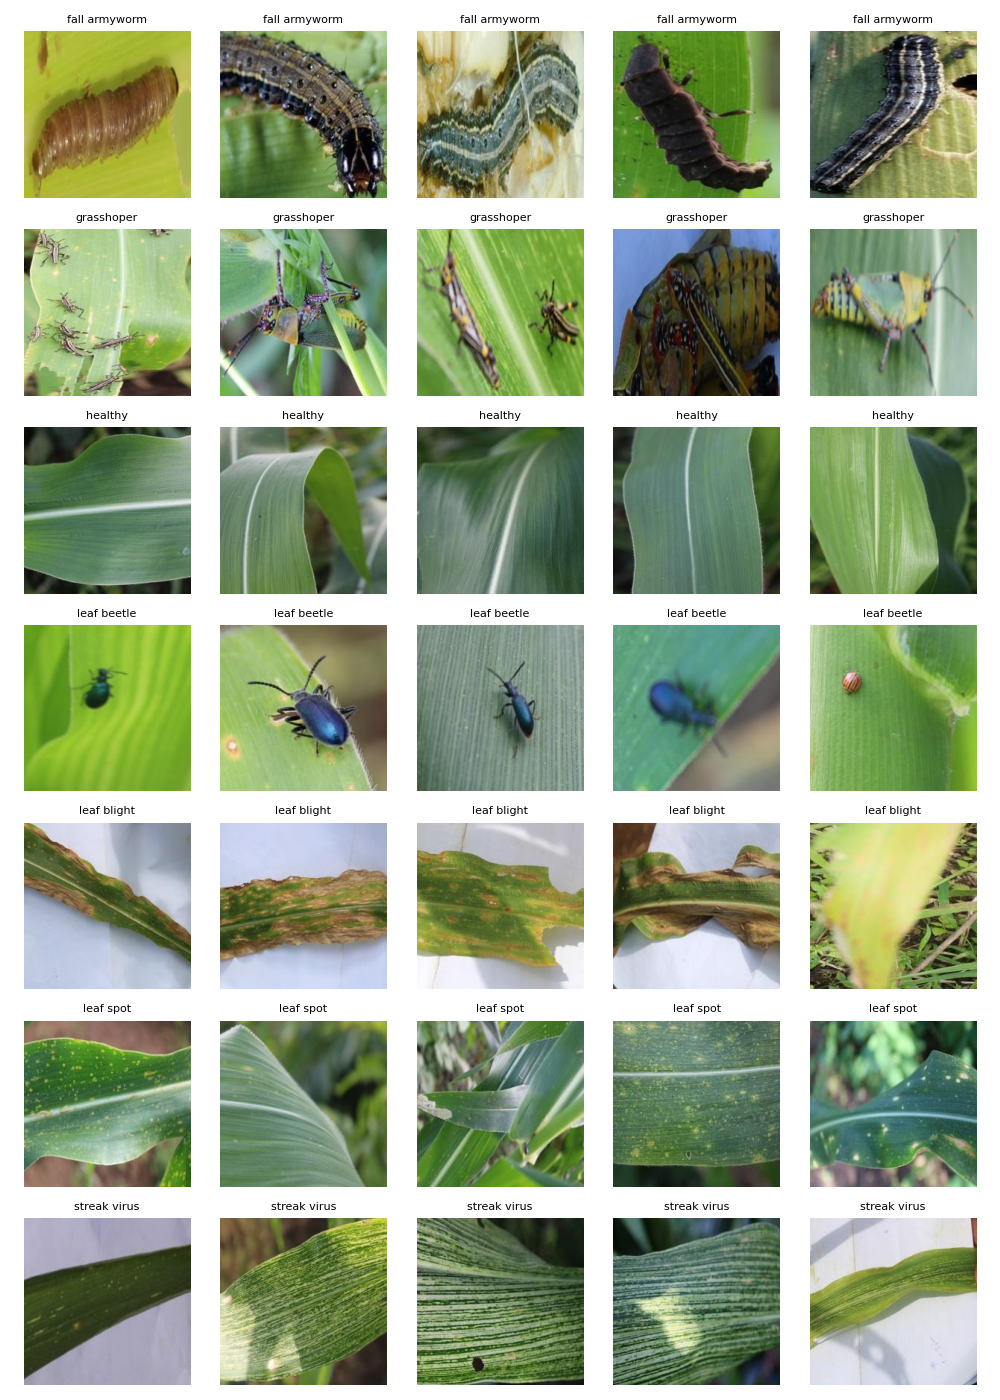

In [9]:
# Display the sample grid image generated by EDA (if present)
from IPython.display import Image, display
grid_path = report_dir / 'sample_grid.png'
if grid_path.exists():
    display(Image(filename=str(grid_path)))
else:
    print('No sample_grid.png found')

Empirical counts after WeightedRandomSampler (simulation):
           class  count  emp_count
0  fall armyworm    116       2908
1     grasshoper    539       2815
2        healthy    166       2847
3    leaf beetle    747       2814
4    leaf blight    792       2893
5      leaf spot    993       2866
6   streak virus    775       2857


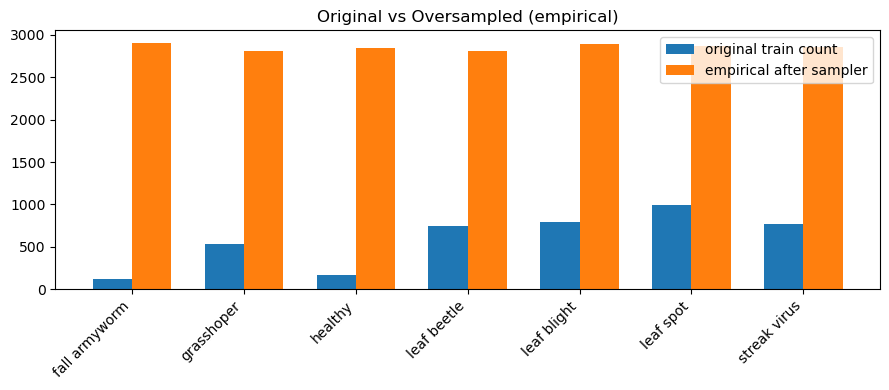

In [11]:
# Simulate WeightedRandomSampler behavior using the train counts
# Compute per-sample weights: weight(sample) = 1 / count(class_of_sample)
labels = np.repeat(df_counts['class'].values, df_counts['count'].values)
class_to_idx = {c: i for i, c in enumerate(df_counts['class'].values)}
idxs = np.array([class_to_idx[l] for l in labels])
sample_weights = 1.0 / df_counts['count'].values[idxs]
# Normalize to probabilities for demonstration (not necessary for sampler)
probs = sample_weights / sample_weights.sum()
# Draw many samples and show the empirical distribution of classes under oversampling
draws = 20000
chosen = np.random.choice(len(labels), size=draws, p=probs)
chosen_labels = labels[chosen]
emp_counts = pd.Series(chosen_labels).value_counts().reindex(df_counts['class'].values).fillna(0).astype(int)
emp_df = pd.DataFrame({'class': emp_counts.index, 'emp_count': emp_counts.values})
emp_df = emp_df.merge(df_counts[['class','count']], on='class')
emp_df['emp_prop'] = emp_df['emp_count'] / emp_df['emp_count'].sum()
print('Empirical counts after WeightedRandomSampler (simulation):')
print(emp_df[['class','count','emp_count']])
# Plot comparison original vs oversampled empirical
plt.figure(figsize=(9,4))
x = np.arange(len(emp_df))
width = 0.35
plt.bar(x - width/2, emp_df['count'], width, label='original train count')
plt.bar(x + width/2, emp_df['emp_count'], width, label='empirical after sampler')
plt.xticks(x, emp_df['class'], rotation=45, ha='right')
plt.legend()
plt.title('Original vs Oversampled (empirical)')
plt.tight_layout()
plt.show()

**How to apply in training**

- To use class-weighted loss: run training with `--class_weighting balanced`.
- To use oversampling: run training with `--oversample`.
- Both can be used together, but watch for overfitting on minority classes.

Example command:
```bash
python -u src/train.py --mode baseline --data_dir data/processed --epochs 10 --oversample --class_weighting balanced
```